### Map me results data separation and clustering

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
#from concave_hull import concave_hull, concave_hull_indexes
# didn't end up using this https://pypi.org/project/concave-hull/
from shapely.constructive import concave_hull
from shapely.geometry import Point, Polygon, LineString, MultiPoint, box
#import sklearn.cluster
from sklearn.cluster import DBSCAN, OPTICS, HDBSCAN

In [3]:
folder = "C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Walkability\\Workshops\\"
proj_crs = 'EPSG:7856'

In [60]:
ids = pd.read_csv(folder + "map-me results\\participant_ids.csv")

In [53]:
blobs = pd.read_csv(folder + "map-me results\\josephine2.csv")
answers = pd.read_csv(folder + "map-me results\\map-me_answers_23-05-2023_06-47.csv")

In [54]:
blobs['geometry'] = gpd.GeoSeries([Point(xy) for xy in zip(blobs['lng'], blobs['lat'])], crs="EPSG:4326")
data = gpd.GeoDataFrame(blobs)

In [55]:
# convert to projected coordinates, EPSG:7856, x and y column / 3857 because conversion to 7856 isn't working / it started working again
data = data.to_crs(proj_crs)
data['x'] = data.geometry.x
data['y'] = data.geometry.y

In [56]:
data['question'] = data['id_question'].replace({20523:1, 20524:2, 20525:3, 20526:4,
                                                20544:1, 20545:2, 20546:3, 20547:4,
                                                20749:1, 20750:2, 20751:3, 20752:4})

In [62]:
# add participant id to data based on ids dataframe
data = data.merge(ids, left_on='id_person', right_on='map_me_id')

In [65]:
# number of unique id_person per question
data.groupby('question')['participant'].nunique()

question
1    119
2     71
3     65
4     55
Name: participant, dtype: int64

In [11]:
sydney_shape = gpd.read_file(folder + "Cedric\\josie_survey_visualisation\\data\\sydney_shape_3857.gpkg")
sydney_shape = sydney_shape.to_crs(proj_crs)

In [66]:
bbox = [245462,6284846,342008,6216330] # not big enough, cuts off Pittwater, need to fix
# 245462,6284846,342008,6216330 is 7856 coords
# 16725461,-3962183,16845397,-4051319 is 3857 coords
# clip data and sydney shape to bbox
data = data.cx[bbox[0]:bbox[2], bbox[3]:bbox[1]]
bounding_box = box(bbox[0], bbox[2], bbox[3], bbox[1])
sydney_crop = sydney_shape.intersection(bounding_box)

## Removal lists

In [67]:
clean_data = data[~(data['id_person'].astype(int) < 81914)]

remove = [81921, 83996, 81948, 83810, 81953, 82797, 81930, 84495, 84597, 84599, 84601, 84626, 84630, 84727, 84746, ]
clean_data = clean_data[~(clean_data['id_person'].isin(remove))]

clean_data['concave'] = 1
loop = [83793, 83994, 84709]
clean_data.loc[clean_data['id_person'].isin(loop),'concave'] = 0

q4loop = [81926, 81937, 82382, 83790, 83998, 84028, 83820, 85444, 84786, 84726]
clean_data.loc[(clean_data['id_person'].isin(q4loop)) & (clean_data['question'] == 4),'concave'] = 0

clean_data = clean_data[~((clean_data['id_person']==85269) & (clean_data['question'].isin([3,4])))]
clean_data = clean_data[~((clean_data['id_person']==85366) & (clean_data['question'].isin([2,3,4])))]
clean_data = clean_data[~((clean_data['id_person'] == 84689) & (clean_data['question'] == 4))]
clean_data = clean_data[~((clean_data['id_person'] == 86245) & (clean_data['zoom'] == 11))]

# person 84821 blobs 26428735:26428745 are faulty but already removed by bbox
#83822 treat Q3 and Q4 as without holes
#81932, 82763 is weird but it can stay

len(data), len(clean_data), len(clean_data)/len(data), clean_data['concave'].sum()

(283751, 254537, 0.8970435346483361, 231761)

In [68]:
(clean_data['concave'].sum() - clean_data[clean_data['question']==3]['concave'].sum() - clean_data[clean_data['question']==4]['concave'].sum())/(len(clean_data[clean_data['question']==1]) + len(clean_data[clean_data['question']==2]))

0.9368125478628357

## Plots one by one to save

In [15]:
def plot_all(data):
    for person in data['id_person'].unique():
        plot_data = data[data['id_person'] == person]
        plot_text = answers[answers['id_person'] == person].iloc[:,[2,4]].values.tolist()

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(36, 18))
        ax.set_aspect('equal')
        sydney_crop.plot(ax=ax, color='lightgrey')

        ax.set_xlim(plot_data['x'].min()-1000, plot_data['x'].max()+1000)
        ax.set_ylim(plot_data['y'].min()-1000, plot_data['y'].max()+1000)
        
        plot_data[plot_data['question'] == 1].plot(ax=ax, color='green')
        plot_data[plot_data['question'] == 2].plot(ax=ax, color='red')
        plot_data[plot_data['question'] == 3].plot(ax=ax, color='pink')
        plot_data[plot_data['question'] == 4].plot(ax=ax, color='blue')

        if len(plot_text) > 1:
            answerstable = plt.table(cellText=[[item[0], item[1][:150]] for item in plot_text],  loc='bottom')
            answerstable.auto_set_font_size(False)
            answerstable.set_fontsize(14)
            answerstable.auto_set_column_width(True)
            answerstable.scale(1, 1.5)
            ax.set_xticks([]) 
            ax.add_table(answerstable)

        ax.set_title('User: '+ str(person))

        # save each plot as a jpg
        plt.savefig(folder + "map-me results\\user_plots_answers\\" + str(person) + ".jpg", dpi=600)

#plot_all(clean_data)

In [16]:
def plot_together(data):
    fig, axes = plt.subplots(nrows=len(data['id_person'].unique())/2, ncols=2, sharey=True, figsize=(36, 18*len(data['id_person'].unique())/2))
    for ax, person in zip(axes.ravel(), data['id_person'].unique()):
        ax.set_aspect('equal')
        sydney_shape.plot(ax=ax, color='lightgrey')

        plot_data = data[data['id_person'] == person]
        ax.set_xlim(plot_data['x'].min()-1000, plot_data['x'].max()+1000)
        ax.set_ylim(plot_data['y'].min()-1000, plot_data['y'].max()+1000)
        plot_data[plot_data['question'] == 1].plot(ax=ax, color='green')
        plot_data[plot_data['question'] == 2].plot(ax=ax, color='red')
        plot_data[plot_data['question'] == 3].plot(ax=ax, color='pink')
        plot_data[plot_data['question'] == 4].plot(ax=ax, color='blue')

        ax.set_title('User: '+person)

## Create clusters

In [187]:
# for each combination of 'id_person' and 'id_question', cluster with DBSCAN and return with a cluster number column
# sorting first is important
cluster_data = clean_data.copy().sort_values(['id_person', 'id_question', 'zoom'])

cluster_12 = cluster_data[(cluster_data['question'] == 1) | (cluster_data['question'] == 2)][['x','y','id_person','id_question']].groupby(['id_person', 'id_question']).apply(lambda x: HDBSCAN(min_cluster_size=30, min_samples=1, cluster_selection_epsilon=900, allow_single_cluster=True).fit_predict(x[['x', 'y']]))
cluster_34 = cluster_data[(cluster_data['question'] == 3) | (cluster_data['question'] == 4)][['x','y','id_person','id_question']].groupby(['id_person', 'id_question']).apply(lambda x: DBSCAN(min_samples=3, eps=700).fit_predict(x[['x', 'y']]))
# need to allow single cluster

cluster_data.set_index(['id_person', 'id_question',], inplace=True)
cluster_data.loc[(cluster_data['question'] == 1) | (cluster_data['question'] == 2),'cluster'] = cluster_12.explode()
cluster_data = cluster_data.reset_index()
cluster_data.set_index(['id_person', 'id_question'], inplace=True)
cluster_data.loc[(cluster_data['question'] == 3) | (cluster_data['question'] == 4),'cluster'] = cluster_34.explode()
cluster_data = cluster_data.reset_index()

cluster_data.loc[(cluster_data['question'] == 1) | (cluster_data['question'] == 2),'unique_cluster'] = cluster_data['id_person'].astype(str) + "-" + cluster_data['question'].astype(str) + "-" + cluster_data['cluster'].astype(str)
cluster_data.loc[(cluster_data['question'] == 3) | (cluster_data['question'] == 4),'unique_cluster'] = cluster_data['id_person'].astype(str) + "-" + cluster_data['question'].astype(str) + "-" + cluster_data['cluster'].astype(str)

In [188]:
cluster_data['unique_cluster'].nunique(), len(cluster_data[(cluster_data['id_person']==83822)&(cluster_data['question']==2)&(cluster_data['cluster']==-1)]), len(cluster_data[cluster_data['cluster']==-1])/len(cluster_data)
# 3337 with first set of data, 5040 with second, 998 with grouping by zoom as well and changing eps
# 920 with large eps for q3 and 4
# 710 with distant zoom eps adjusted to look after 83822 better
# 1329 with HDBSCAN, 1174 with single clusters allowed for q 3 and 4, 1146 with distance 300 for q 3 and 4
# 1136 with DBSCAN, eps 700 for q 3 and 4 which I think is better
# 1108 with min samples 4 for HDBSCAN
#30 seems best

(652, 328, 0.007000946817162142)

33

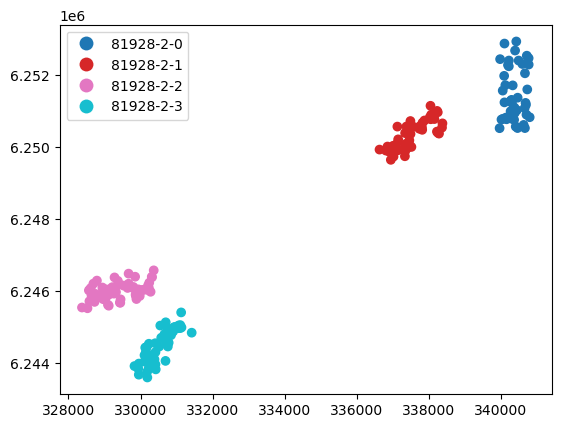

In [225]:
#84786, 83822, 85269, 83793 - that one is tricky circular one
#85532, 82785, 85077
# q1 and 2 ones that look dodgy in Qgis: 84576-1-14-11, 81936-1-16-1
cluster_data[(cluster_data['id_person']==81928)&(cluster_data['question']==2)&(cluster_data['cluster']<100)].plot(column='unique_cluster', legend=True)
#&(cluster_data['cluster']==-1)
len(cluster_data[(cluster_data['id_person']==84576)&(cluster_data['question']==1)&(cluster_data['cluster']==2)])

In [201]:
cluster_data[(cluster_data['id_person']==83822)&(cluster_data['question']==2)].groupby('cluster').count()

,id_person,id_question,id_blob,spray_number,lat,lng,time_blob,zoom,geometry,x,y,question,map_me_id,participant,concave,unique_cluster
cluster,,,,,,,,,,,,,,,,
-1,328,328,328,328,328,328,328,328,328,328,328,328,328,328,328,328
0,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50
1,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176
2,202,202,202,202,202,202,202,202,202,202,202,202,202,202,202,202
3,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30
4,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167
5,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36
6,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42
7,107,107,107,107,107,107,107,107,107,107,107,107,107,107,107,107


In [202]:
# this is a good test to check that not many people have had their question 4 answer split up 
cluster_data[cluster_data['question']==4].groupby(['id_person']).nunique()
# this one is good to check number of clusters per question overall
cluster_data.groupby(['question']).nunique()
# 83772 genuinely has multiple clusters for question 4 - did not answer the question as intended. For these people, need to select the largest cluster as their 'walkable neighbourhood' (or exclude them from averages)

,id_person,id_question,id_blob,spray_number,lat,lng,time_blob,zoom,geometry,x,y,map_me_id,participant,concave,cluster,unique_cluster
question,,,,,,,,,,,,,,,,
1,98,2,113989,6,32027,15959,104626,9,113733,113733,113733,98,98,2,15,282
2,64,2,62296,4,40464,26147,57076,7,62193,62193,62193,64,64,2,20,246
3,56,2,47967,2,20809,11278,47792,8,47786,47786,47786,56,56,2,4,67
4,50,2,30285,2,18405,12030,30275,8,30266,30266,30266,50,50,2,5,57


## Concave hulls for clusters


### create_hulls

In [22]:
def shapely_hulls_1(cluster_data, ratio=None, verbose=False):
    # this version applies a small buffer around the points prior to hull creation
    # ratio is optional, if it is not set, a variable ratio is calculated based on the number of points in each cluster. The variable ratio has a minimum value of 0.1 and a maximum value of 0.6
    polygons = gpd.GeoDataFrame()
    for cluster in cluster_data['unique_cluster'].unique():
        #print(cluster)
        num = cluster_data[cluster_data['unique_cluster'] == cluster].iloc[0]['cluster']
        if num == -1:
            #print(cluster, 'point - nonclustered')
            gs = gpd.GeoSeries(MultiPoint(cluster_data[cluster_data['unique_cluster'] == cluster][['x', 'y']].values))
        else:
            if cluster_data[cluster_data['unique_cluster'] == cluster].iloc[0]['concave'] == 1:
                #points = cluster_data[cluster_data['unique_cluster'] == cluster][['x', 'y']].values
                #print(cluster, points)
                buffered_geom = cluster_data[cluster_data['unique_cluster'] == cluster].apply(lambda x: Point(x['x'], x['y']).buffer(10), axis = 1)
                vertices = np.concatenate([np.array(geometry.exterior.coords) for geometry in buffered_geom])
                points = np.array(vertices)
                n = len(cluster_data[cluster_data['unique_cluster'] == cluster])
                geometry = MultiPoint(points)

                if n > 2:
                    zoom = round(cluster_data[cluster_data['unique_cluster'] == cluster]['zoom'].mean())
                    if ratio:
                        flexible_ratio = ratio
                    else:
                        flexible_ratio = max(0.6*math.exp(-0.0017*n), 0.1)
                    gs = gpd.GeoSeries(concave_hull(geometry, ratio=flexible_ratio, allow_holes=False))
                    if verbose:
                        print(cluster, n, ratio, flexible_ratio, zoom)
                elif n > 1:
                    #print(cluster, 'line')
                    gs = gpd.GeoSeries(LineString(cluster_data[cluster_data['unique_cluster'] == cluster][['x', 'y']].values))
                else:
                    #print(cluster, 'point')
                    gs = gpd.GeoSeries(Point(cluster_data[cluster_data['unique_cluster'] == cluster][['x', 'y']].values))
            else:
                #print(cluster, 'convex')
                s = cluster_data[cluster_data['unique_cluster'] == cluster].geometry
                gs = gpd.GeoSeries(s.unary_union.convex_hull)

        polygon = gpd.GeoDataFrame(geometry=gs)
        polygon['unique_cluster'] = cluster
        polygon['concave'] = cluster_data[cluster_data['unique_cluster'] == cluster].iloc[0]['concave']
        
        polygons = pd.concat([polygons, polygon])
    return polygons

### Create all hulls

In [203]:
hulls = shapely_hulls_1(cluster_data)
#9 minutes for 150k blobs and also for 250k blobs. 4 mins once cluster number reduced.
# 11 mins with buffering. 18 mins for some reason. 26 mins with the new ratio

<AxesSubplot: >

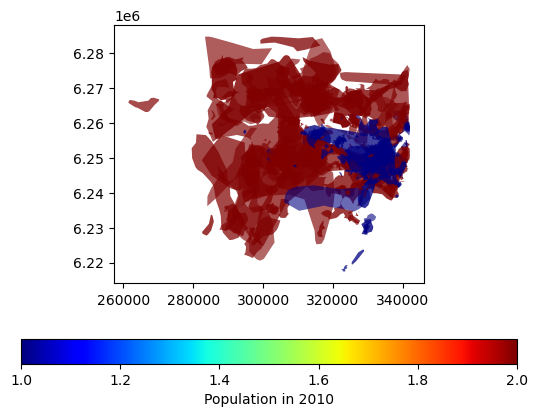

In [204]:
hulls['area'] = hulls['geometry'].area
hulls['id_person'] = hulls['unique_cluster'].str.split('-', expand=True)[0].astype(int)
hulls['question'] = hulls['unique_cluster'].str.split('-', expand=True)[1].astype(int)
hulls = hulls.merge(ids, left_on='id_person', right_on='map_me_id')

hulls['cluster'] = hulls['unique_cluster'].str.split('-', expand=True)[2]
hulls['unclustered'] = hulls['unique_cluster'].str.split('-', expand=True)[3]  

d = min(np.log(hulls[~(hulls['area']==0)].area/max(hulls[~(hulls['area']==0)].area)))//1
hulls[(~(hulls['area'] == 0))&((hulls['question'] == 1) | (hulls['question'] == 2))].plot(
    'question', alpha=0.5*(1+np.log(hulls[~(hulls['area'] == 0)].area/max(hulls[~(hulls['area'] == 0)].area))/d),
    legend=True,
    legend_kwds={"label": "Population in 2010", "orientation": "horizontal"},
    cmap="jet"
)

<AxesSubplot: >

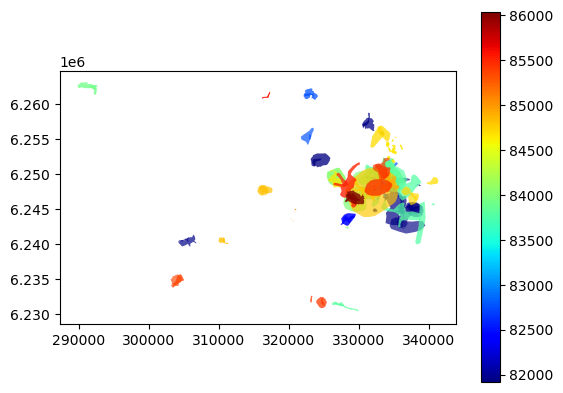

In [25]:
hulls[(~(hulls['area'] == 0))&((hulls['question'] == 3) | (hulls['question'] == 4))].plot(
    'id_person', alpha=0.5*(1+np.log(hulls[~(hulls['area'] == 0)].area/max(hulls[~(hulls['area'] == 0)].area))/d),
    legend=True,
    cmap="jet"
)

In [26]:
# create histogram of hulls.area
hulls[hulls['question'] == 2].sort_values('area', ascending=False).head(10)

,geometry,unique_cluster,concave,area,id_person,question,cluster,unclustered
0,"POLYGON ((300154.472 6270025.967, 300154.616 6...",82762-2-0,1,1.899270e+08,82762,2,0,None
0,"POLYGON ((293022.265 6246560.791, 293022.409 6...",83801-2-1,1,1.827778e+08,83801,2,1,None
0,"POLYGON ((279531.492 6252765.692, 279531.636 6...",83924-2-1,1,1.754545e+08,83924,2,1,None
0,"POLYGON ((282439.443 6249300.927, 282439.587 6...",84718-2-1,1,1.381080e+08,84718,2,1,None
0,"POLYGON ((293672.029 6273667.718, 293672.173 6...",83924-2-4,1,1.080968e+08,83924,2,4,None
0,"POLYGON ((306534.154 6269528.579, 306534.298 6...",82382-2-1,1,9.521797e+07,82382,2,1,None
0,"POLYGON ((299909.943 6263928.610, 299910.087 6...",84821-2-0,1,9.467782e+07,84821,2,0,None
0,"POLYGON ((337622.293 6271230.943, 337622.437 6...",83998-2-0,1,9.214878e+07,83998,2,0,None
0,"POLYGON ((293526.795 6250109.980, 293526.939 6...",83924-2-2,1,8.862161e+07,83924,2,2,None
0,"POLYGON ((284050.019 6238986.386, 284050.163 6...",83772-2-4,1,7.839749e+07,83772,2,4,None


### Testing

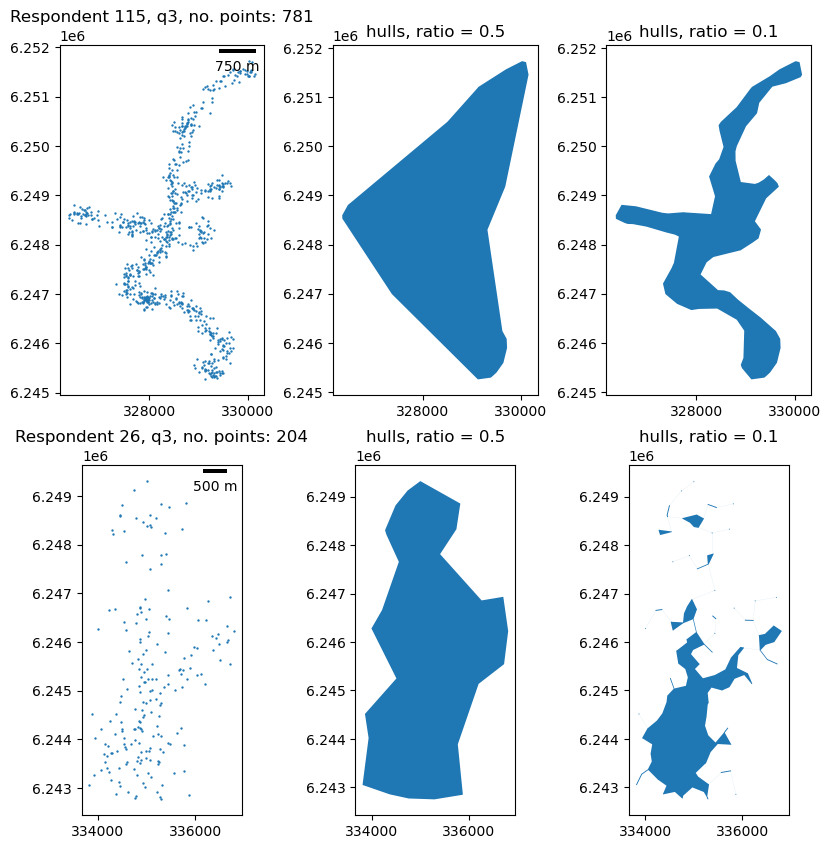

In [215]:
fig, ax = plt.subplots(2, 3, figsize=(10, 10))
for i, person in enumerate([85532, 81942]):
    data = cluster_data[(cluster_data['id_person']==person) & (cluster_data['question']==3)]
    participant = ids[ids['map_me_id']==person].iloc[0]['participant']

    ax[i, 0].set_title('Respondent ' + str(participant) + ', q3, ' + 'no. points: ' + str(len(data)))
    ax[i, 0].add_artist(ScaleBar(1, frameon=False))
    data.plot(ax=ax[i, 0], markersize=0.5)

    ax[i, 1].set_title('hulls, ratio = 0.5')
    shapely_hulls_1(data, ratio=0.5).plot(ax=ax[i, 1])

    ax[i, 2].set_title('hulls, ratio = 0.1')
    #data['geometry'] = data.apply(lambda x: Point(x['x'], x['y']).buffer(10), axis=1)
    shapely_hulls_1(data, ratio=0.1).plot(ax=ax[i,2])  

plt.savefig(folder + "map-me results\\ratio_comparison_wide_0.1.jpg", dpi=600)


## Export

In [205]:
# counts points per unique_cluster in cluster_data
cluster_data['unique_cluster'].value_counts()
# add counts to hulls
hulls['count'] = hulls['unique_cluster'].map(cluster_data['unique_cluster'].value_counts())
# add point density
hulls['density'] = hulls['count']/hulls['area']

In [206]:
# export cluster_data as gpkg
cluster_data.drop(columns=['x','y','concave','lat','lng','cluster']).to_file(folder + 'Cedric\\josie_survey_visualisation\\data\\cluster_data_17_9th.gpkg', driver='GPKG')

In [207]:
# export hulls as gpkg
hulls.set_crs(proj_crs, inplace=True)
hulls.to_file(folder + 'Cedric\\josie_survey_visualisation\\data\\hulls_17_9th.gpkg', driver='GPKG')

In [208]:
# export cluster_data as csv
cluster_data.to_csv(folder + 'Cedric\\josie_survey_visualisation\\data\\cluster_data_17_9th.csv')

## Hull size analysis

In [5]:
ratios = pd.DataFrame(columns=['id_person', 'ratio'], data={'id_person':hulls['id_person'].unique(),})

# find the ratio of q3 and q4 area
for person in hulls['id_person'].unique():
    q3size = hulls[(hulls['question']==3) & (hulls['id_person'] == person)]['area'].max()
    q4size = hulls[(hulls['question']==4) & (hulls['id_person'] == person)]['area'].max()
    #print(person, q3size, q4size)
    ratios.loc[ratios['id_person']==person, 'q3size'] = q3size
    ratios.loc[ratios['id_person']==person, 'q4size'] = q4size   
    if q4size != 0:
        ratios.loc[ratios['id_person']==person, 'ratio'] = q3size/q4size

# find the hausdorff distances for q3 and q4
for person in hulls['id_person'].unique():
    if ratios.loc[ratios['id_person']==person, 'q3size'].iloc[0] > 0:
        # find centroid of largest hull for question 3
        q3centroid = hulls[(hulls['question']==3) & (hulls['id_person'] == person)].sort_values('area', ascending=False).iloc[0]['geometry'].centroid
        # find perimeter of largest hull for question 3, as LineString
        q3perimeter = hulls[(hulls['question']==3) & (hulls['id_person'] == person)].sort_values('area', ascending=False).iloc[0]['geometry'].boundary
        # hausdorff distance between q3centroid and q3perimeter
        q3haus = q3centroid.hausdorff_distance(q3perimeter)
        ratios.loc[ratios['id_person']==person, 'hausdorff3'] = q3haus
    if ratios.loc[ratios['id_person']==person, 'q4size'].iloc[0] > 0:
    # find centroid of largest hull for question 4
        q4centroid = hulls[(hulls['question']==4) & (hulls['id_person'] == person)].sort_values('area', ascending=False).iloc[0]['geometry'].centroid
        # find perimeter of largest hull for question 4, as LineString
        q4perimeter = hulls[(hulls['question']==4) & (hulls['id_person'] == person)].sort_values('area', ascending=False).iloc[0]['geometry'].boundary
        # hausdorff distance between q4centroid and q4perimeter
        q4haus = q4centroid.hausdorff_distance(q4perimeter)
        ratios.loc[ratios['id_person']==person, 'hausdorff4'] = q4haus

In [6]:
ratios.ratio.mean()

0.8987194671499665

In [8]:
ratios.hausdorff3.mean(), ratios.hausdorff4.mean(), ratios.hausdorff3.median(), ratios.hausdorff4.median(), 1/ratios.ratio.median()

(1278.779927019224,
 1484.8462142849828,
 1125.1976341977925,
 1424.5769350562891,
 3.075192578239611)

In [284]:
ratios.sort_values(by='ratio', ascending=True).head(10)

,id_person,ratio,q3size,q4size,hausdorff3,hausdorff4
89,85444,0.005951,4.287407e+04,7.204866e+06,360.011184,2087.757395
42,83820,0.015568,1.361252e+05,8.743648e+06,657.325969,2693.099716
35,83790,0.027534,3.015828e+05,1.095295e+07,901.771389,2557.129143
12,81935,0.034222,2.044257e+05,5.973527e+06,691.340063,2295.260170
41,83816,0.067748,2.573591e+05,3.798785e+06,1128.271346,1472.033197
63,84662,0.068896,1.879986e+05,2.728742e+06,648.127880,1712.864345
24,82762,0.092082,1.829256e+05,1.986562e+06,420.351623,1404.481884
76,84786,0.10367,4.115540e+06,3.969845e+07,2738.210191,3931.061075
55,84028,0.123474,6.210294e+05,5.029633e+06,1122.156041,1432.972637
51,84002,0.137413,6.598755e+04,4.802132e+05,484.800580,941.008831


In [215]:
# which hull has the largest q4size
hulls[(hulls['question']==3)].sort_values('area', ascending=False).head()

,geometry,unique_cluster,concave,area,id_person,question,zoom,cluster,unclustered,count,density
0,"POLYGON ((319233.887 6248192.129, 319234.031 6...",85077-3-10.0-0,1,2.332007e+07,85077,3,NaN,10.0,0,35,0.000002
0,"POLYGON ((332023.836 6249771.344, 332023.980 6...",82785-3-14.0-0,1,1.573391e+07,82785,3,NaN,14.0,0,1757,0.000112
0,"POLYGON ((326362.645 6248593.841, 326362.789 6...",85532-3-14.0-0,1,1.273676e+07,85532,3,NaN,14.0,0,781,0.000061
0,"POLYGON ((334275.789 6248307.375, 334275.933 6...",81942-3-12.0-0,1,1.249453e+07,81942,3,NaN,12.0,0,204,0.000016
0,"POLYGON ((333179.942 6245281.148, 333180.086 6...",83772-3-14.0-0,1,1.038787e+07,83772,3,NaN,14.0,0,466,0.000045


<AxesSubplot: >

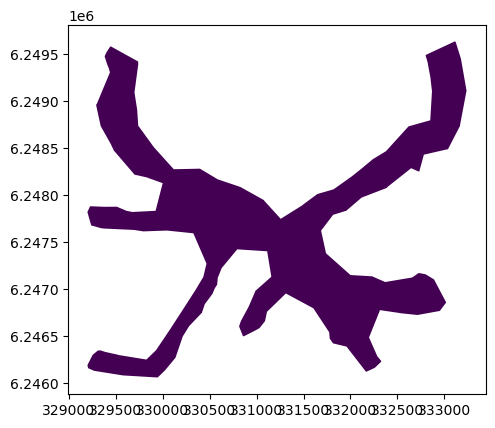

In [11]:
hulls[(hulls['id_person']==84786)&(hulls['question']==3)].plot('question')

### export some per person stats ie radius

In [12]:
ratios.to_csv('q34hullsizes_17_9.csv')

### Time taken

In [473]:
cluster_data.iloc[11].time_blob - cluster_data.iloc[10].time_blob, cluster_data.iloc[12].time_blob - cluster_data.iloc[11].time_blob

(-13, 27)

In [477]:
cluster_data.groupby(['id_person']).apply(lambda x: (max(x.time_blob)-min(x.time_blob))/1000/60).describe()

count    99.000000
mean      8.067656
std       9.701168
min       0.007933
25%       1.371700
50%       5.774033
75%      10.690750
max      53.741350
dtype: float64

In [479]:
cluster_data.groupby(['id_person']).apply(lambda x: (max(x.time_blob)-min(x.time_blob))/1000/60).sort_values()

id_person
84685     0.007933
81914     0.009400
84725     0.026933
82043     0.028833
81934     0.042617
           ...    
84709    29.549950
83822    37.585883
83801    39.802700
84659    41.637217
83786    53.741350
Length: 99, dtype: float64

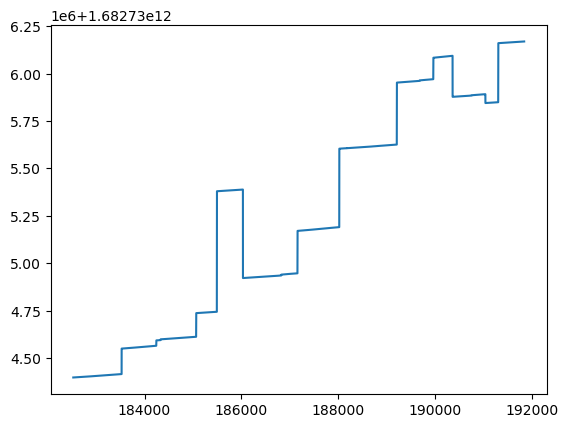

In [491]:
plt.plot(cluster_data[cluster_data['id_person']==84709]['time_blob'])